# Investigate Bering-Chukchi surface flux-wind-transport anomaly feedback

**Turn this notebook into one that finds the trend of the observational fields using linear regression of the monthly anomalies and only plots the statistically significant linear trends in the observations of the surface fields**




Danielson et al. 2020 propose a feedback loop for Arctic amplification where the elevated ocean temperatures in the summer and fall lead to an enhanced ocean to atmosphere heat flux that strengthens the northward winds through Bering Strait. The change in wind strength increases Bering Strait volume transports through stronger, northward geostrophic currents in Bering Strait.

This notebook compares the time series of the monthly anomalies for:
1. summer/fall Chukchi Sea SST
2. summer/fall surface heat fluxes over the Chukchi Sea
3. fall winds over the Bering strait
4. fall Bering Strait ocean heat and volume fluxes

First we just want to see if there is a corresponding increase in the meridional wind anonmaly over time for the Bering Strait region in the observations (using ERA 5 monthly winds).

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

## Set observational paths

In [3]:
# SST
sst_dir = '/work/Marion.Alberty/data/OISST_pp/'
# Heat fluxes
hF_dir = '/uda/ERA5/Monthly_Averaged_Data_On_Single_Levels/reanalysis/global/annual_file-range/Mean_rates/'
# Winds
v10_dir = '/work/Marion.Alberty/data/ERA5_pp/v_10m/'
# Transports
T_path = '../data/BeringStraitMooring/'

## Get file lists

In [4]:
# SST
flist_sst = glob(f'{sst_dir}NCEI_OISST_monthly_SST_*.nc')
# Heat fluxes
flist_sw = glob(f'{hF_dir}mean_surface_net_short-wave_rad_flux/*.nc')
flist_lw = glob(f'{hF_dir}mean_surface_net_long-wave_rad_flux/*.nc')
flist_lt = glob(f'{hF_dir}mean_surface_latent_heat_flux/*.nc')
flist_sn = glob(f'{hF_dir}mean_surface_sensible_heat_flux/*.nc')
# Winds
flist_v10 = glob(f'{v10_dir}ERA5_monthly_v_10m_*.nc')
# Transports
flist_T = f'{T_path}BeringStrait_Monthlymeans_Jan2021.nc'

## Read in observational data

In [5]:
def fix_latlon(ds):
    # Rename to lat, lon
    ds = ds.rename({'longitude':'lon','latitude':'lat'})
    # reindex for increasing lat
    ds = ds.reindex(lat=list(reversed(ds.lat)))
    return ds

In [6]:
# SST
DS_sst = xr.open_mfdataset(flist_sst,engine='netcdf4')

In [7]:
# Winds
DS_v10 = fix_latlon(xr.open_mfdataset(flist_v10,engine='netcdf4'))

In [8]:
# Transports
DS_T = xr.open_dataset(flist_T,engine='netcdf4')

## Maps of analysis region

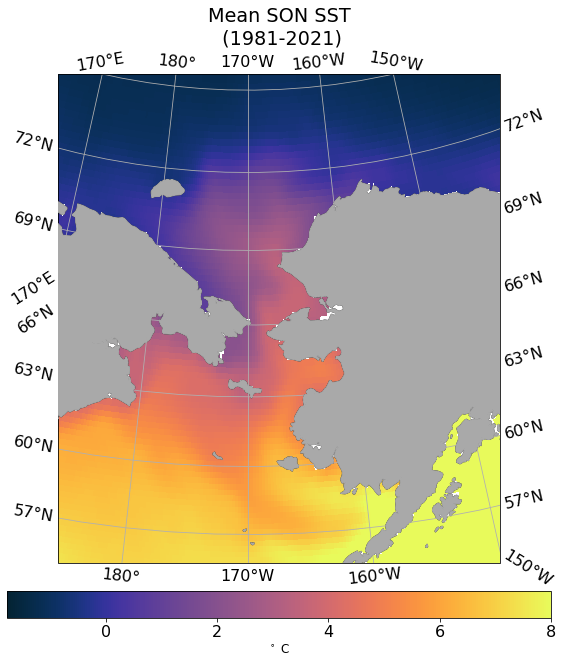

In [9]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_sst['lon']
Y = DS_sst['lat']
Z = DS_sst['sst'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.thermal',vmax=8)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON SST\n ({DS_sst.time.dt.year.values[0]}-{DS_sst.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ$ C',fontsize=12)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

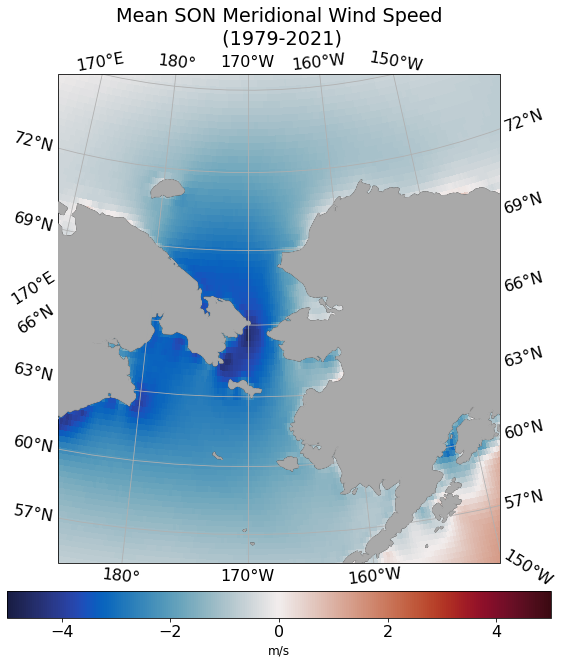

In [10]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_v10['lon']
Y = DS_v10['lat']
Z = DS_v10['v10'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.balance',vmin=-5, vmax=5)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON Meridional Wind Speed\n ({DS_v10.time.dt.year.values[0]}-{DS_v10.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('m/s',fontsize=12)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

## Set lat,lon for analysis

In [11]:
lats = np.array([50, 80])
lons = np.array([160, 230])

## Extract regions for analysis

In [12]:
# SST
sst = DS_sst.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))

In [13]:
# Heat fluxes

In [14]:
# Winds
v10 = DS_v10.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))

In [15]:
# Transport
T = DS_T

## Calulate linear regressions on monthly anomalies
Following the method for calculating standard error as is given on pages 250-254 of Thomson and Emery

In [22]:
def linReg_clim(ds):
    def mk_lr(ds,mon):
        # get linear regression coefficients for Jan and initialize dataset
        lr = ds.isel(time=ds.groupby('time.month').groups[mon]).polyfit(
            'time',1,full=True).assign_coords(month=mon).expand_dims('month')
        # rename coefficients
        lr = lr.rename({[s for s in list(lr.keys()) if "coefficients" in s][0]:'b0_b1'})
        # rename sum of squared errors
        lr = lr.rename({[s for s in list(lr.keys()) if "residuals" in s][0]:'SSE'})
        # add sample size
        lr['N'] = (('month'),[len(ds.isel(time=ds.groupby('time.month').groups[mon]).time)])
        # calculate the standard error of the estimate
        lr['s_err'] = (lr['SSE']/ lr['N']-2)**(1/2)
        # calc spread in time
        dt = (ds.isel(time=ds.groupby('time.month').groups[mon]).time - 
              ds.isel(time=ds.groupby('time.month').groups[mon]).time.mean()).astype(float).values
        # calculate the standard error of the slope (dea)
        lr['s_b1'] = lr['s_err']/((dt**2).sum()**(1/2))
        return lr
    # get linear regression coefficients for Jan and initialize dataset
    LR = mk_lr(ds,1)
    for i in range(2,13):
        # calc lin regress for next month
        _LR = mk_lr(ds,i)
        # concat with previous months
        LR = xr.concat([LR, _LR],"month")
    return LR

In [23]:
# SST
LR_sst = linReg_clim(sst)

In [24]:
LR_sst

<xarray.Dataset>
Dimensions:               (degree: 2, lat: 120, lon: 280, month: 12)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 50.12 50.38 50.62 ... 79.38 79.62 79.88
  * lon                   (lon) float64 160.1 160.4 160.6 ... 229.4 229.6 229.9
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    time_matrix_rank      (month) int64 2 2 2 2 2 2 2 2 2 2 2 2
    time_singular_values  (month, degree) float64 1.393 0.2468 ... 1.392 0.2494
    b0_b1                 (month, degree, lat, lon) float64 dask.array<chunksize=(1, 2, 120, 280), meta=np.ndarray>
    SSE                   (month, lat, lon) float64 dask.array<chunksize=(1, 120, 280), meta=np.ndarray>
    N                     (month) int64 40 40 40 40 40 40 40 40 41 41 41 41
    s_err                 (month, lat, lon) float64 dask.array<chunksize=(1, 120, 280), meta=np.ndarray>
    s_b1                  (month, lat, lon) float64 dask.array<chunksize=(1, 120, 280), meta=np.ndarray>

In [25]:
# winds
LR_v10 = linReg_clim(v10)

In [26]:
t_con = 1e9 * 86400 * 365.25

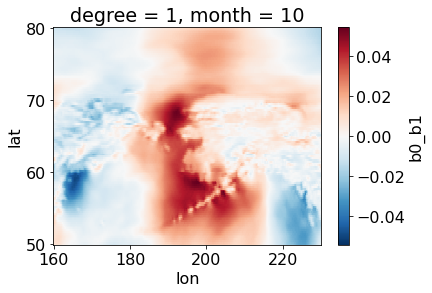

In [28]:
(t_con * LR_v10['b0_b1'].sel(degree=1,month=10)).plot()